
__Equação SARIMA__\
Uma equação típica do modelo SARIMA se parece com o seguinte –

$SARIMA(p,d,q)\times(P,D,Q)_{lag}$

Os parâmetros para esses tipos de modelos são os seguintes:

__p__ e sazonal __P__: indicam o número de termos AR (defasagens da série estacionária)\
__d__ e sazonal __D__: indicam diferenciações que devem ser feitas para as séries tornarem-se estacionárias\
__q__ e __Q__ sazonal: indicam o número de termos MA (lags dos erros da previsão)\
__lag__: indica o intervalo da sazonalidade nos dados

__Fazendo com que uma série temporal torne-se estacionária__

Uma série temporal estacionária é aquela que não possui nenhuma tendência ou sazonalidade. É essencial lidar com qualquer tendência ou sazonalidade antes de modelar os dados da série temporal porque se as propriedades estatísticas não mudarem ao longo do tempo, torna-se mais fácil modelar os dados com precisão. Uma das maneiras populares de se fazer com que a série torne-se estacionária é __diferenciando__.

__Modelagem SARIMA__


Plote a série - para verificar se há discrepâncias\
Transforme os dados (para tornar a média e a variância constantes)\
Aplique testes estatísticos para verificar se a série é estacionária (tanto de tendência quanto de sazonalidade)\
Se não estacionário (ou seja, se possui tendência ou sazonalidade), torne-a estacionária diferenciando\
Plote ACF de séries estacionárias para ordem MA, ordem MA sazonal em picos sazonais\
Traçar PACF de séries estacionárias para ordem AR, ordem AR sazonal em picos sazonais\
Execute SARIMA com esses parâmetros\
Verifique a validade do modelo usando gráficos de resíduos

In [1]:
from datetime import datetime

t1 = datetime.now()
t1

datetime.datetime(2022, 4, 29, 21, 20, 0, 615462)

In [2]:
from constantes import *

In [3]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from joblib import Parallel # Processamento paralelo
from multiprocessing import cpu_count
from joblib import delayed

In [4]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [5]:
#define function for kpss test
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
      kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [6]:
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

#### Carregando os dados pré-processados para o modelo

In [7]:
filepath = "..\data\processed\CATEG_2.csv"
df = pd.read_csv(filepath).sort_values(by = ["DATE"])
df.head(3)

,DATE,UNITS_SOLD
16,2018-10-16,1
768,2019-06-11,15
492,2019-06-12,13


In [8]:
df = df[df["DATE"] > "2018-10-16"]
df['DATE'] = pd.to_datetime(df['DATE'])
df['UNITS_SOLD'] = df['UNITS_SOLD'].astype(float)
df.head(3)

,DATE,UNITS_SOLD
768,2019-06-11,15.0
492,2019-06-12,13.0
28,2019-06-13,8.0


In [9]:
df.isnull().sum()
df = df.dropna()
df.isnull().sum()

DATE          0
UNITS_SOLD    0
dtype: int64

In [10]:
df = df.set_index('DATE')

#### Será definida uma reamostragem com medias semanais para a análise. Pois será mais expressiva a métrica de sazonalidade a seguir.

[dataframe.resample](https://www.geeksforgeeks.org/python-pandas-dataframe-resample/)

In [11]:
# reamostragem pela média semanal
ts_month_avg = df['UNITS_SOLD'].resample(f'{LAPSO_MEAN_2}D').mean()
ts_month_avg = ts_month_avg.dropna()
ts_month_avg = ts_month_avg.asfreq(f'{LAPSO_MEAN_2}D', method='ffill') # Incluindo uma configuração de frequência

In [12]:
L = len(ts_month_avg)
train_df = ts_month_avg[0:int(L*TRAINNG_DATA_PERCENTAGE_2)]
test_df = ts_month_avg[int(L*TRAINNG_DATA_PERCENTAGE_2):int(L*(TRAINNG_DATA_PERCENTAGE_2 + TEST_DATA_PERCENTAGE_2))]
validation_df = ts_month_avg[int(L*(TRAINNG_DATA_PERCENTAGE_2 + TEST_DATA_PERCENTAGE_2)):]

__Gráfico dos dados__

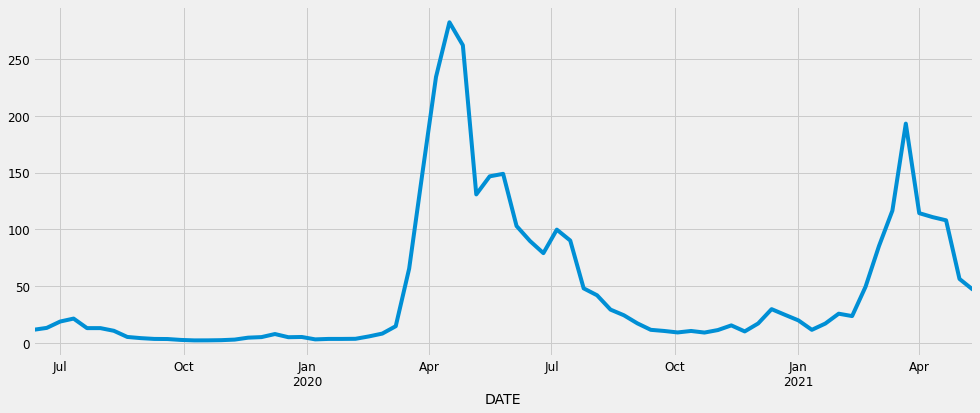

In [13]:
train_df.plot(figsize=(15, 6))
plt.show()


__Identificando Variação, Tendência e Sazonalidade nos dados__\
Vamos verificar a tendência e os componentes sazonais dos dados. Cada série temporal pode ser decomposta em 3 componentes

Tendência\
Sazonalidade\
Ruído

Vamos ver nossa série temporal decomposta –

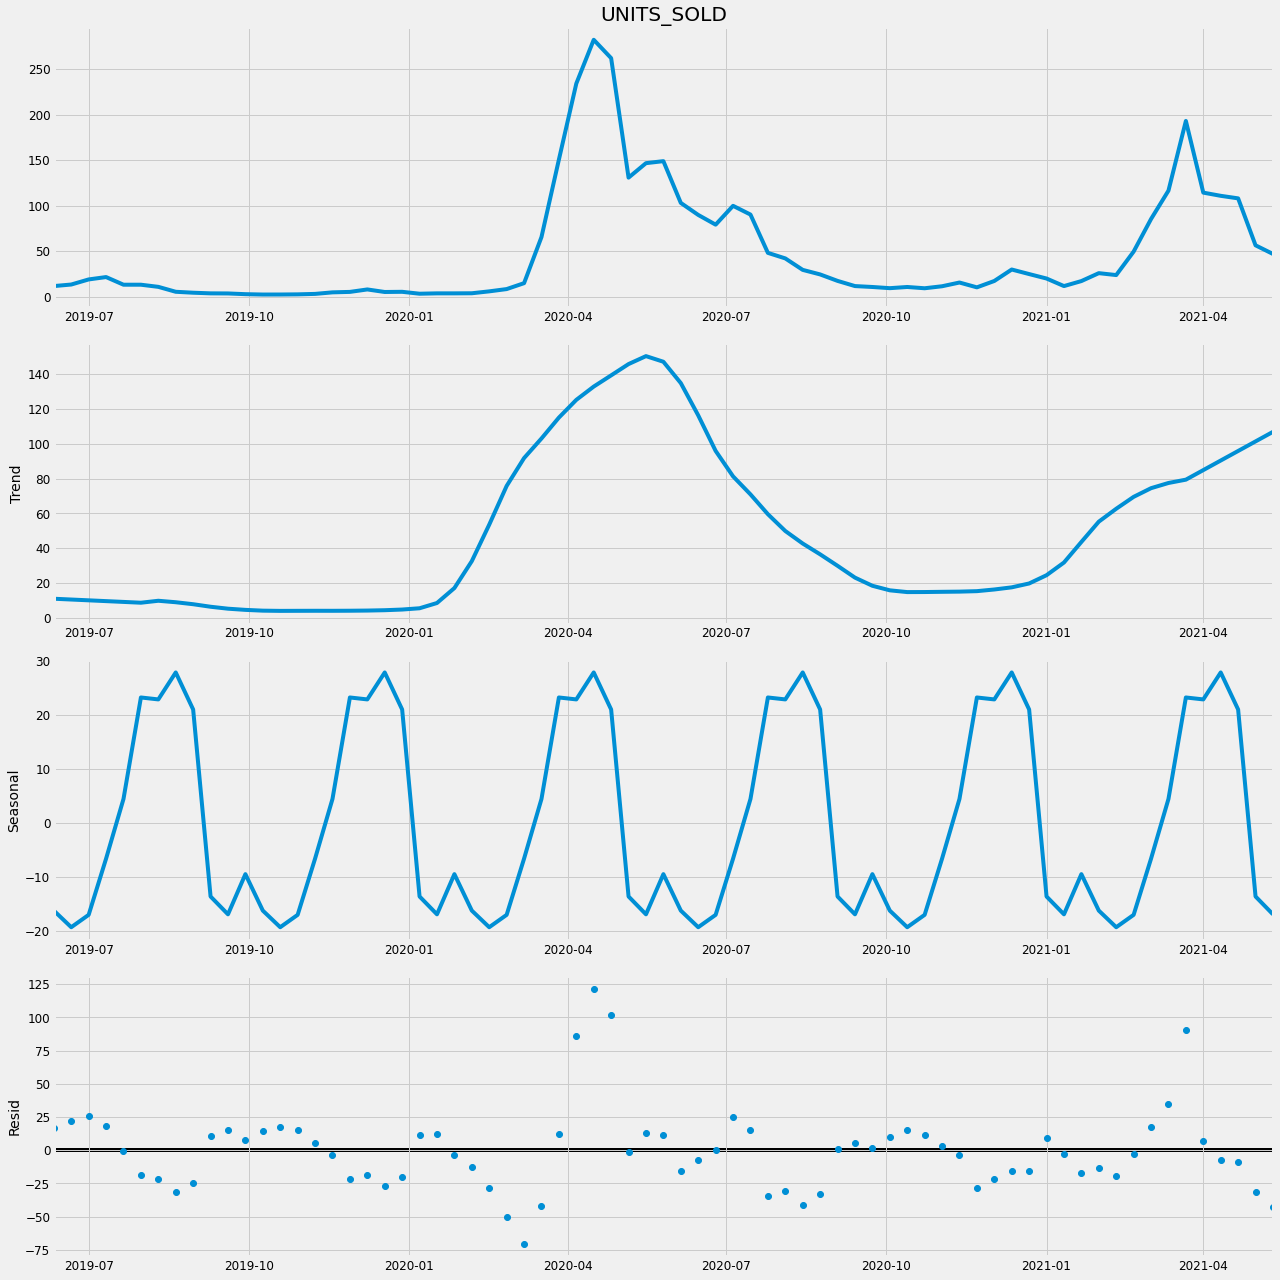

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 18
decomposition = sm.tsa.seasonal_decompose(train_df, model='additive',period=12, extrapolate_trend = 12)
fig = decomposition.plot()
plt.show()

Como podemos ver, há uma tendência de alta e uma sazonalidade semestral (6 x 4 semans por mês implica um lag = 24) nos dados. Portanto, a série não é estacionária. Temos que lidar com a sazonalidade analisar o efeito. Será realizada a diferenciação e será verificado o resultado por testes estatísticos como ADF (para tendência) e OSCB (para sazonalidade).

Regra de polegar para testes estatísticos -
ADF(para tendência): se o valor p for menor que o valor crítico, a série é estacionária
OSCB(para sazonalidade): se o valor for menor que 0,64, a série é estacionária

In [15]:
LAGS = int(SAZONALITY_MONTHS_2*(30/LAPSO_MEAN_2))
LAGS = int(LAGS*LAG_REDUCTION_FACTOR_2)
LAGS

9

In [16]:
print(adf_test(train_df))

Results of Dickey-Fuller Test:
Test Statistic                 -2.662749
p-value                         0.080709
#Lags Used                      1.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64
None


Depois de executar o teste ADF na série temporal, obtemos  __p__ = __0.112672__ que é maior que o valor crítico de 0,05. Assim podemos confirmar estatisticamente que a série não é estacionária. Portanto, podemos realizar uma diferenciação de primeira ordem para a tendência e executamos novamente o teste ADF para verificar a estacionariedade.

<AxesSubplot:xlabel='DATE'>

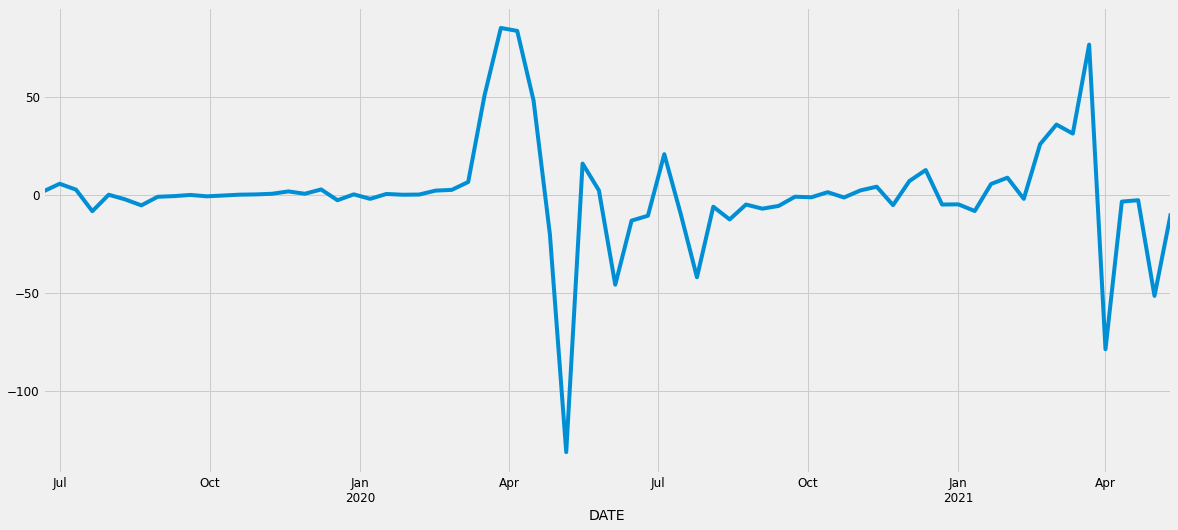

In [17]:
rcParams['figure.figsize'] = 18, 8
ts_t_adj = train_df - train_df.shift(1)
ts_t_adj = ts_t_adj.dropna()
ts_t_adj.plot()

In [18]:
print(adf_test(ts_t_adj))

Results of Dickey-Fuller Test:
Test Statistic                -6.254852e+00
p-value                        4.364102e-08
#Lags Used                     0.000000e+00
Number of Observations Used    6.900000e+01
Critical Value (1%)           -3.528890e+00
Critical Value (5%)           -2.904440e+00
Critical Value (10%)          -2.589656e+00
dtype: float64
None


Observando o __p-value__ a __tendência__ agora parece ter desaparecido. O valor p é menor que o valor crítico de 0,05. Portanto, podemos confirmar que a série agora é uma tendência estacionária.

Passemos agora para a diferenciação __sazonal__. Como os dados estão mostrando uma sazonalidade semestral, realizaremos uma diferenciação com defasagem 15 dias => 12 lags.

<AxesSubplot:xlabel='DATE'>

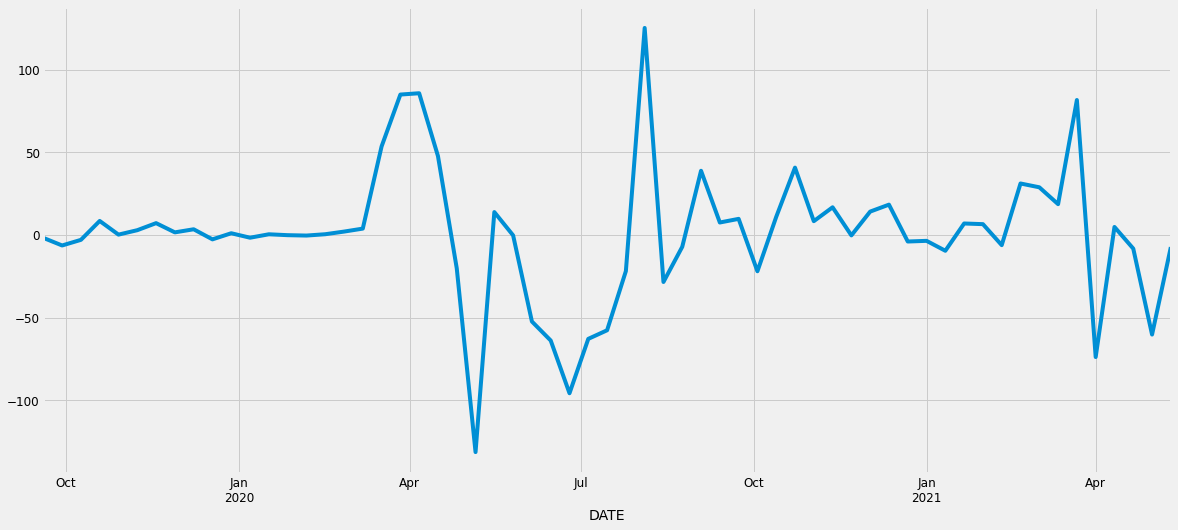

In [19]:
ts_s_adj = ts_t_adj - ts_t_adj.shift(LAGS)
ts_s_adj = ts_s_adj.dropna()
ts_s_adj.plot()

Agora que os dados estão estacionários, vamos para a próxima etapa do processo – os gráficos ACF e PACF.

Parcelas ACF e PACF

Vamos tentar descobrir os parâmetos do modelo 

Para descobrir isso , precisaríamos traçar os gráficos ACF e PACF.

ACF significa Função de Correlação Automática e PACF significa Função de Correlação Automática Parcial.

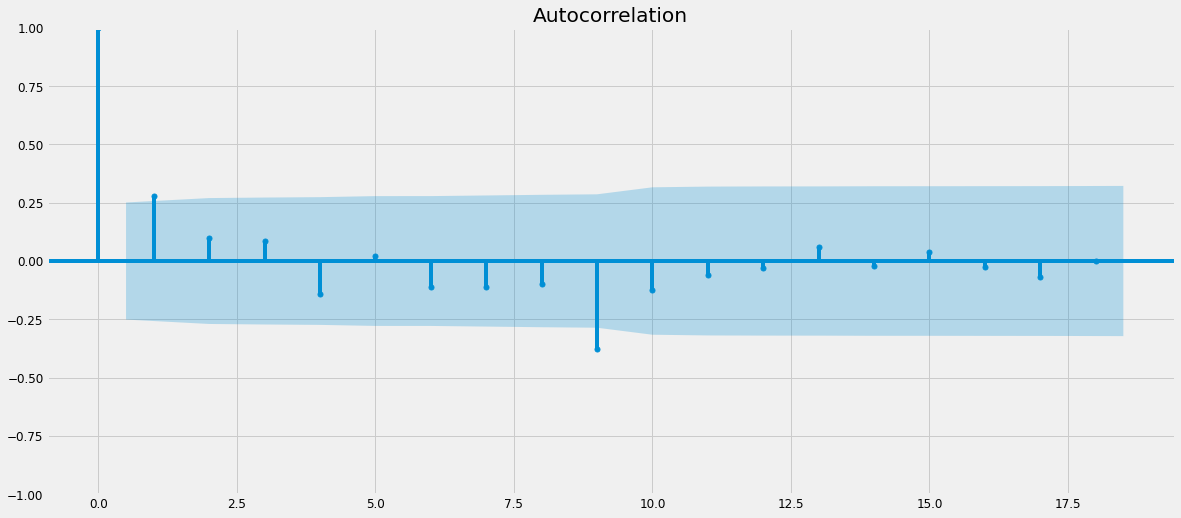

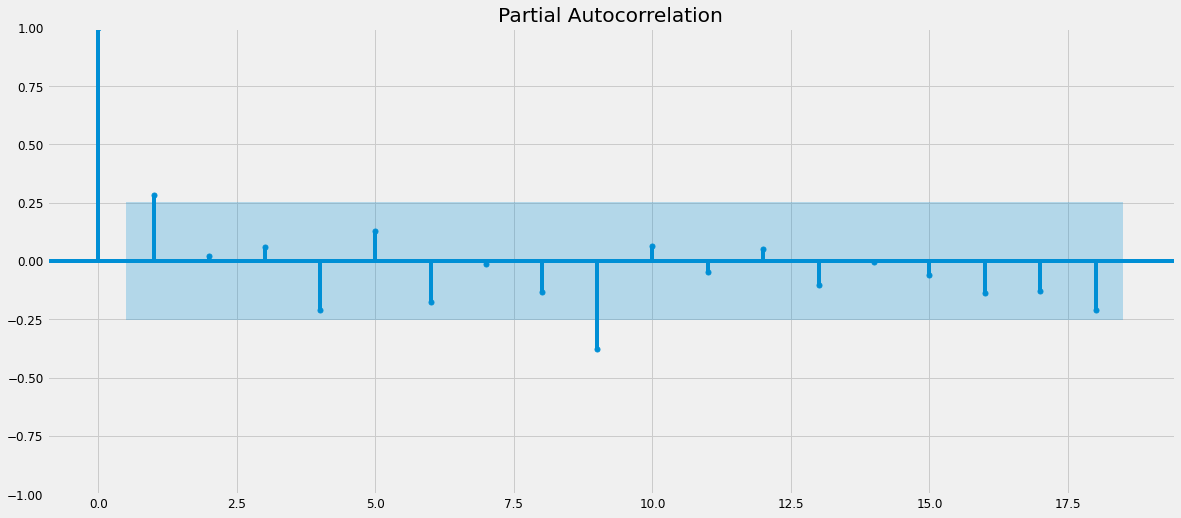

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_s_adj)
matplotlib.pyplot.show()
plot_pacf(ts_s_adj)
matplotlib.pyplot.show()

$SARIMA(p,d,q)\times(P,D,Q)_{lag}$

Os parâmetros para esses tipos de modelos são os seguintes:

__p__ e sazonal __P__: indicam o número de termos AR (defasagens da série estacionária)\
__d__ e sazonal __D__: indicam diferenciações que devem ser feitas para as séries tornarem-se estacionárias\
__q__ e __Q__ sazonal: indicam o número de termos MA (lags dos erros da previsão)\
__lag__: indica o intervalo da sazonalidade nos dados

__Estimando termos de AR, ou p__

O gráfico de pirulito que você vê acima são os resultados do ACF e do PACF. Para estimar a quantidade de termos AR, você precisa olhar para o gráfico PACF. Primeiro, ignore o valor na defasagem 0. Ele sempre mostrará uma correlação perfeita, pois estamos estimando a correlação entre o valor de hoje consigo mesmo. Observe que há uma área azul no gráfico, representando o intervalo de confiança. Para estimar quantos termos de AR você deve usar, comece a contar quantos “pirulito” estão acima ou abaixo do intervalo de confiança antes que o próximo entre na área azul.

p = 1


__Estimativa de termos I, ou d__

Esta é uma parte fácil. Tudo o que você precisa fazer para estimar a quantidade de I(d) termos é saber quantas diferenciações foram usadas para tornar a série estacionária. Por exemplo, se você usou diferença logarítmica ou primeira diferença para transformar uma série temporal, a quantidade de termos I será 1, pois Arauto toma a diferença entre o valor real (por exemplo, o valor de hoje) e 1 valor anterior (por exemplo, o valor de ontem).

d = 1

__Estimando termos de MA, ou q__

Assim como a função PACF, para estimar a quantidade de termos MA, desta vez você observará o gráfico ACF. A mesma lógica é aplicada aqui: quantos pirulitos estão acima ou abaixo do intervalo de confiança antes que o próximo pirulito entre na área azul?

q = 1

__Estimando termos sazonais de RA, ou P__
Caso seus dados possuam sazonalidade e você queira utilizar um modelo Sazonal ARIMA, é necessário informar os termos sazonais para AR, I e MA. O processo é bastante semelhante ao AR não sazonal, e você ainda usará a função ACF e PACF para isso. Para estimar a quantidade de termos AR, você examinará mais uma vez a função PACF. Agora, em vez de contar quantos pirulitos estão fora do intervalo de confiança, você contará quantos pirulitos sazonais estão fora.

Como os dados possuem sazonalidade semestral, é preciso verificar se o “pirulito” na defasagem 6 está fora da área do intervalo de confiança. Em caso de resultado positivo, é necessário adicionar 1 termo para AR Sazonal. Como temos um pirulito negativo na posição 6 adicionamos 1.

P = 0

__Estimating Seasonal I terms__

A mesma lógica de estimar a diferenciação não sazonal é aplicada aqui. Se você usou a diferenciação sazonal para tornar a série temporal estacionária (por exemplo, o valor real (Yt) subtraído por 12 meses anteriores (Yt-12)), você adicionará 1 termo à diferenciação sazonal.

D = 1

__Estimating Seasonal MA terms__

Para a média móvel sazonal (SMA), estaremos olhando para o gráfico ACF e usaremos a mesma lógica de estimar os termos SAR.
Como só temos uma correlação forte em 4 temos, estimamos que o valor deve ser 0 ou 1.

Q = 0

lag = 18

Portanto,

$SARIMA(p,d,q)\times(P,D,Q)_{lag}$
$SARIMA(0,1,0)\times(1,1,1)_{26}$


### A seguir são realizadas algumas combinações de parâmetros para serem restados nas tentavas de otimizações a seguir utilizando a métrica AIC para a avaliação do modelo treinado.

In [21]:
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = []
for x in list(itertools.product(p, d, q)):
    seasonal_pdq.append((x[0], x[1], x[2], LAGS) )

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
TOTAL_TEST = len(pdq)*len(seasonal_pdq)
print(f"Serão realizado {TOTAL_TEST} testes no total.")

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 9)
SARIMAX: (0, 0, 1) x (0, 0, 2, 9)
SARIMAX: (0, 0, 2) x (0, 1, 0, 9)
Serão realizado 324 testes no total.


### A seguir é construído um script que testa combinações dos parâmetros e mede a métrica AIC para verificar qual a melhor combinação testada.

In [22]:
from operator import itemgetter
params_list = []
params_list_top = []
cont = 0
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_df,
                                            order= param,
                                            seasonal_order=param_seasonal,
                                            )
            results = mod.fit(method = 'powell')
            # param = (1, 1, 1)
            cont +=1
            print(f"Teste {cont}/{TOTAL_TEST}")
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            params_list.append([param, param_seasonal, results.aic])
            params_list_sort = []
            params_list_sort = sorted(params_list, key=itemgetter(2))
            params_list_sort_1 = params_list_sort[0]
            params_list_sort_2 = params_list_sort[2]
            params_list_sort_3 = params_list_sort[3]
            params_list_sort_4 = params_list_sort[4]
            params_list_sort_5 = params_list_sort[5]
            print(f'TOP 1 SARIMA params: {params_list_sort_1[0]}x{params_list_sort_1[1]} - AIC:{params_list_sort_1[2]}')
            print(f'TOP 2 SARIMA params: {params_list_sort_2[0]}x{params_list_sort_2[1]} - AIC:{params_list_sort_2[2]}')
            print(f'TOP 3 SARIMA params: {params_list_sort_3[0]}x{params_list_sort_3[1]} - AIC:{params_list_sort_3[2]}')
            print(f'TOP 4 SARIMA params: {params_list_sort_4[0]}x{params_list_sort_4[1]} - AIC:{params_list_sort_4[2]}')
            print(f'TOP 5 SARIMA params: {params_list_sort_5[0]}x{params_list_sort_5[1]} - AIC:{params_list_sort_5[2]}')
        except:
            continue

params_list_sort = []
params_list_sort = sorted(params_list, key=itemgetter(2))[0]
print(f'Best SARIMA params: {params_list_sort[0]}x{params_list_sort[1]} - AIC:{params_list_sort[2]}')

Optimization terminated successfully.
         Current function value: 5.796024
         Iterations: 1
         Function evaluations: 23
Teste 1/324
ARIMA(0, 0, 0)x(0, 0, 0, 9) - AIC:825.0353479072921
Optimization terminated successfully.
         Current function value: 5.749328
         Iterations: 2
         Function evaluations: 42
Teste 2/324
ARIMA(0, 0, 0)x(0, 0, 1, 9) - AIC:820.4045464844088
Optimization terminated successfully.
         Current function value: 5.748543
         Iterations: 2
         Function evaluations: 81
Teste 3/324
ARIMA(0, 0, 0)x(0, 0, 2, 9) - AIC:822.2931320665633
Optimization terminated successfully.
         Current function value: 5.198527
         Iterations: 2
         Function evaluations: 37
Teste 4/324
ARIMA(0, 0, 0)x(0, 1, 0, 9) - AIC:740.1908646484559
Optimization terminated successfully.
         Current function value: 5.038626
         Iterations: 3
         Function evaluations: 77
Teste 5/324
ARIMA(0, 0, 0)x(0, 1, 1, 9) - AIC:719.484957369

````
Teste 324/324
ARIMA(2, 1, 2)x(2, 1, 2, 9) - AIC:616.5304567354972
TOP 1 SARIMA params: (0, 1, 1)x(0, 1, 1, 9) - AIC:605.8520415784828
TOP 2 SARIMA params: (0, 1, 0)x(0, 1, 1, 9) - AIC:607.6515491970355
TOP 3 SARIMA params: (0, 1, 1)x(1, 1, 1, 9) - AIC:607.7866085120966
TOP 4 SARIMA params: (0, 1, 1)x(0, 1, 2, 9) - AIC:607.8262215648899
TOP 5 SARIMA params: (0, 1, 2)x(0, 1, 1, 9) - AIC:607.834186410971
Best SARIMA params: (0, 1, 1)x(0, 1, 1, 9) - AIC:605.8520415784828
```

In [23]:
mod = sm.tsa.statespace.SARIMAX(train_df,
                                order=params_list_sort[0], # Best paramns
                                seasonal_order=params_list_sort[1]) # Best paramns
results = mod.fit(method = 'powell')
print(results.summary().tables[1])

Optimization terminated successfully.
         Current function value: 4.224310
         Iterations: 4
         Function evaluations: 144
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2593      0.102      2.537      0.011       0.059       0.460
ma.S.L9       -0.9293      0.780     -1.191      0.233      -2.458       0.599
sigma2       846.5888    538.907      1.571      0.116    -209.650    1902.827


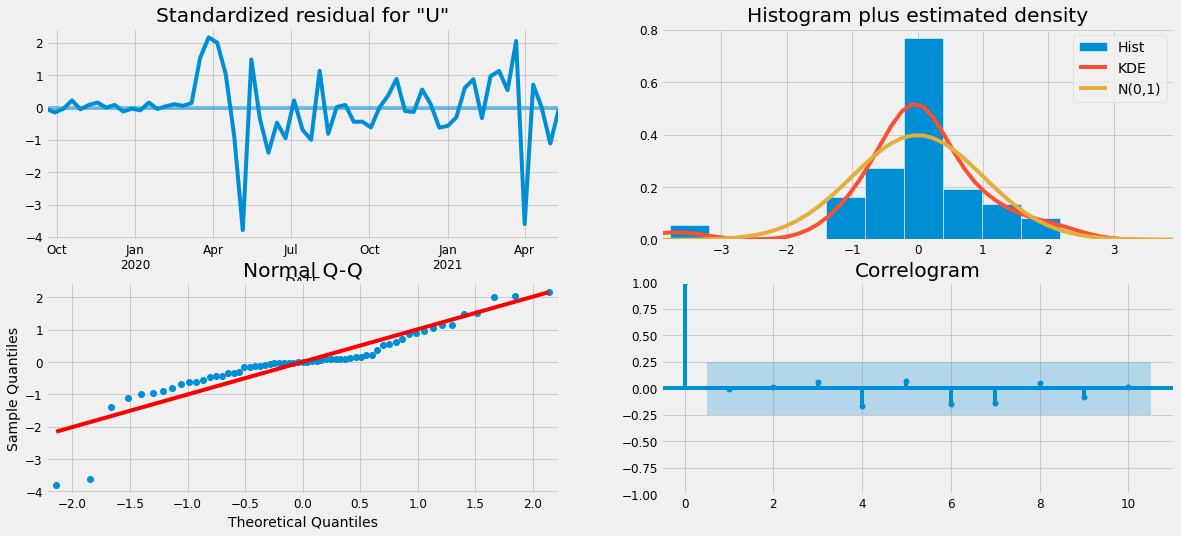

In [24]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [25]:
START_TIME_PREDICTION = train_df.index.max()
START_TIME_PREDICTION

Timestamp('2021-05-11 00:00:00', freq='10D')

In [26]:
import datetime
END_TIME_PREDICTION = validation_df.index.max() + datetime.timedelta(days=+120)

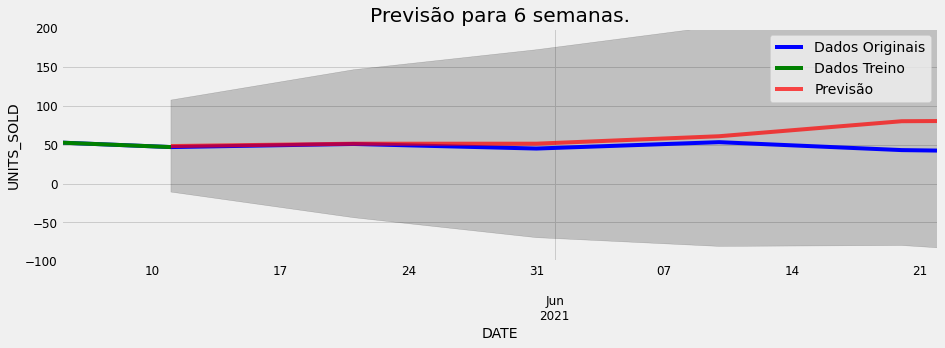

In [27]:
pred = results.get_prediction(start=START_TIME_PREDICTION, dynamic=True, end=END_TIME_PREDICTION)
pred_ci = pred.conf_int(alpha=0.05)
ax = ts_month_avg.plot(label='Dados Originais', color = "blue")
ax = train_df.plot(label='Dados Treino', color = "green")
pred.predicted_mean.plot(ax=ax, label='Previsão', alpha=.7, figsize=(14, 4), color = "red")
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('DATE')
ax.set_ylabel('UNITS_SOLD')
plt.ylim([-100, 200])

TIME_INTERAVAL_TO_OBSERVE_IN_WEEKS = 6

TIME_INTERAVAL_TO_OBSERVE = TIME_INTERAVAL_TO_OBSERVE_IN_WEEKS*7
 
plt.xlim([START_TIME_PREDICTION + datetime.timedelta(days=-TIME_INTERAVAL_TO_OBSERVE/8), START_TIME_PREDICTION + datetime.timedelta(days=TIME_INTERAVAL_TO_OBSERVE)])
plt.title(f"Previsão para {TIME_INTERAVAL_TO_OBSERVE_IN_WEEKS} semanas.")
plt.legend()
plt.show()

In [28]:
from datetime import datetime
t2 = datetime.now()
dt = t2 - t1
print(f"O tempo total para rodar o sript foi de {dt}")

O tempo total para rodar o sript foi de 0:01:22.468281
